# Image Processing SS 20 - Assignment - 05

### Deadline is 27.5.2020 at 11:55am

Please solve the assignments together with a partner.
I will run every notebook. Make sure the code runs through. Select `Kernel` -> `Restart & Run All` to test it.
Please strip the output from the cells, either select `Cell` -> `All Output` -> `Clear` or use the `nb_strip_output.py` script / git hook.

In [1]:
# display the plots inside the notebook
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
from skimage.data import chelsea
from skimage.color import rgb2gray

import random
from io import BytesIO
    
from PIL import Image
import itertools

pylab.rcParams['figure.figsize'] = (12, 8)   # This makes the plot bigger

# Exercise 1 - Filters - 5 Points

Implement and apply the filters below to noisy images. Plot the noisy image vs the filtered one

In [3]:
img = rgb2gray(chelsea() / 255.)
img.shape

(300, 451)

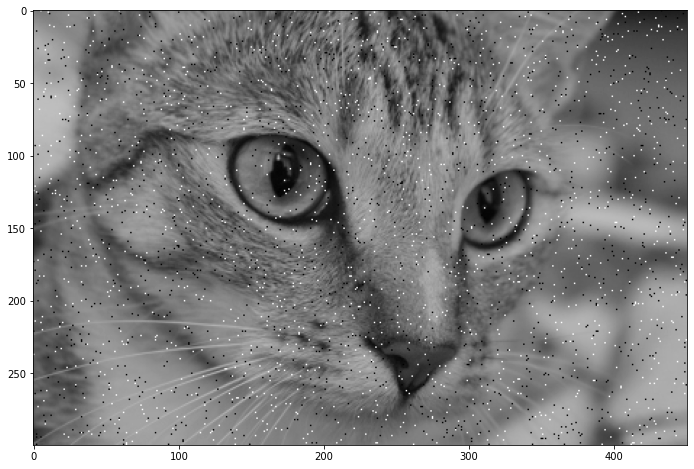

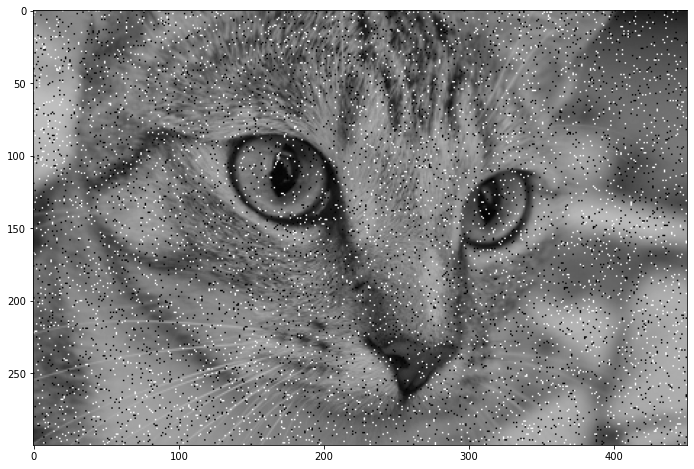

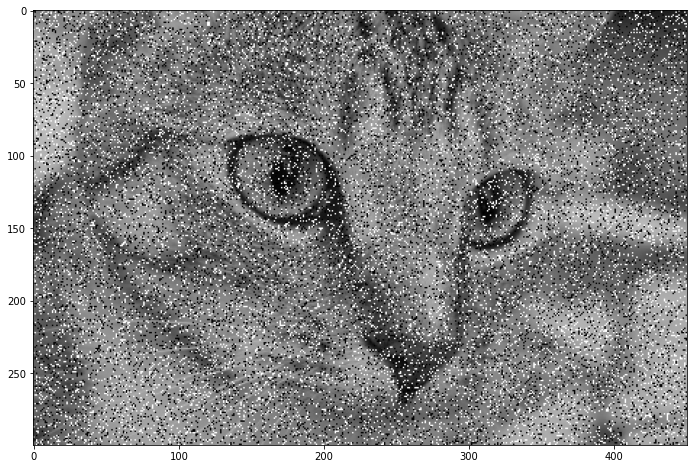

In [4]:
def salt_peper(img, p):
    peper_mask = np.random.binomial(1, p, img.shape).astype(np.bool)
    salt_mask = np.random.binomial(1, p, img.shape).astype(np.bool)
    img_noise = img.copy()
    img_noise[peper_mask] = 0
    img_noise[salt_mask] = 1
    return img_noise

salt_peper_noises = [0.01, 0.03, 0.1]
imgs_salt_peper = [salt_peper(img, p) for p in salt_peper_noises]
for img_salt_peper in imgs_salt_peper:
    plt.imshow(img_salt_peper, cmap='gray')
    plt.show()

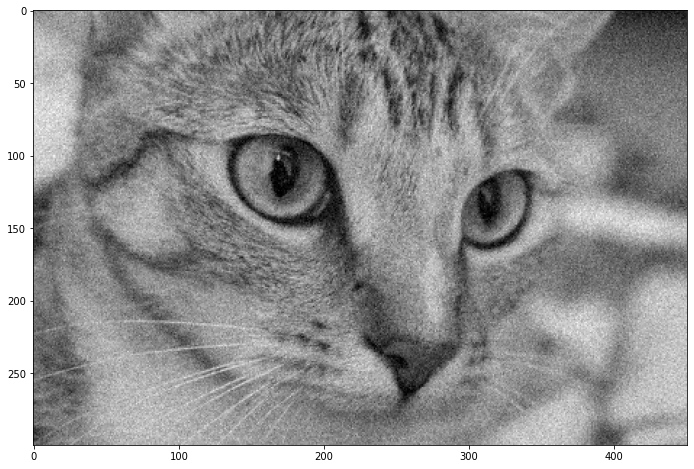

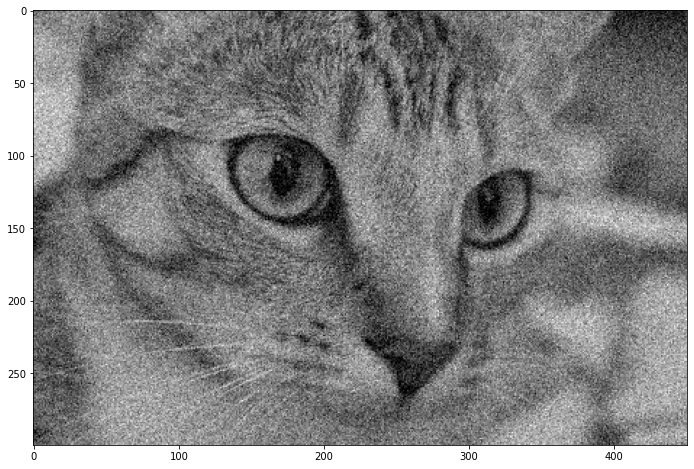

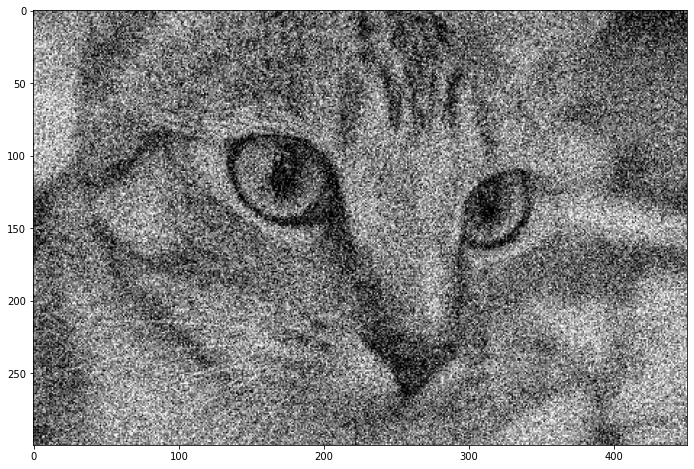

In [5]:
def gaussian_noise(img, std):
    return np.clip(img + np.random.normal(0, std, img.shape), 0, 1)

gaussian_noises = (0.05, 0.10, 0.2)
imgs_gaussian_noise = [gaussian_noise(img, s) for s in gaussian_noises]
for img_gaussian in imgs_gaussian_noise:
    plt.imshow(img_gaussian, cmap='gray')
    plt.show()

In [10]:
# implement the filters:
"""
Convolution is a simple mathematical operation which is fundamental to many common image processing operators. 
Convolution provides a way of `multiplying together' two arrays of numbers, generally of different sizes, 
but of the same dimensionality, to produce a third array of numbers of the same dimensionality
"""
import scipy.signal
from scipy.stats.mstats import gmean

basic_kernel = np.ones((3, 3))
basic_kernel_size = np.size(basic_kernel)
lower_y = 1
lower_x = 1

#---- helper functions ----
def get_filter_frame(img, position_row, position_column):
    # convolution requires values from pixels outside of the image boundaries
    # we will cut the picture in advance and the filtered image will be smaller
    
    frame = np.zeros_like(basic_kernel)
    filtered_row = position_row - 1
    filtered_column = position_column - 1
    
    # no exeptions if we call function without cutting
    #if position_row == 0 or position_column == 0 or position_row == img.shape[1]-1 or position_column == img.shape[0]-1:
        # frame of ones returns
        # probably not the best solution but will help to skip the exeptions
        #return(frame)
    
    # filter frame is not outside the image boundaries
    # copy the 9 pixels surrounding central pixel into filter frame
    #else:
    for row in range(basic_kernel.shape[0]):
        for column in range(basic_kernel.shape[1]):
            frame[row, column] = img[filtered_row, filtered_column]
            filtered_column = filtered_column + 1
        filtered_column = position_column - 1
        filtered_row = filtered_row + 1
    return frame
    
#--------------------------

def arithmetic_mean(img):
    kernel = basic_kernel * 1/9
    
    # Numpy is not a solution because it works only with 1D array (object too deep for desired array)
    #return np.convolve(img[:,:], kernel, mode="same")
    return scipy.signal.convolve2d(img[:,:], kernel, mode='same')

def geometric_mean(img):
    result = np.zeros_like(img)
    upper_x = result.shape[1]-1
    upper_y = result.shape[0]-1

    for row in range(lower_y, upper_y):
        for column in range(lower_x, upper_x):
            img_frame = get_filter_frame(img, row, column)
            result[row, column] = np.prod(img_frame).astype(np.float) ** (1 / float(basic_kernel_size))
    return result

def contraharmoic_mean(img, q=None):
    pepper_noise = 0.8
    salt_noise = -0.8
    # Your need to select the q yourself
    # Q is the order of the filter.
    # Positive values of Q eliminate pepper noise. Negative values of Q eliminate salt noise.
    # It cannot eliminate both simultaneously.
    result = np.zeros_like(img)
    upper_x = result.shape[1]-1
    upper_y = result.shape[0]-1
    
    if q is None or q == 0:
        q = pepper_noise
    

    for row in range(lower_y, upper_y):
        for column in range(lower_x, upper_x):
            img_frame = get_filter_frame(img, row, column)
            nominator = np.sum(img_frame ** (q + 1)) / float(basic_kernel_size)
            denominator = np.sum(img_frame ** q) / float(basic_kernel_size)
            
            # RuntimeWarning: divide by zero encountered in true_divide -> set demominator manually to a very small value
            if denominator == 0:
                denominator = 0.0001
                
            result[row, column] = nominator / denominator
    return result

def adaptive_mean(img):
    result = np.zeros_like(img)
    upper_x = result.shape[1]-1
    upper_y = result.shape[0]-1
    # Operate on a local and based on
    # 1. The value of the noisy image at pixel (x,y) 
    # 2. The variance of the noise
    # 3. The local mean of the pixels in the local region
    # 4. The local variance
    
    var = np.var(img)
    
    for row in range(lower_y, upper_y):
        for column in range(lower_x, upper_x):            
            img_frame = get_filter_frame(img, row, column)
            local_var = np.var(img_frame)
            local_mean = np.mean(img_frame)
            # the value of noisy image is accessible in the loop

            # zero-noise case, copy-paste the original pixel into result
            if var == 0:
                result[row, column] = img[row, column]
            # if the local variance is high relative to global variance, the filter should return the value close
            # to g(x, y). A high local variance typically is accossiated with edges and those should be preserved
            if local_var > var:
                result[row-1 : row+2, column-1 : column+2] = img_frame - ((var**2 / local_var**2) * (img_frame - local_mean))
            # it the two variances are equal, we want a filter to return the arithmetic mean value of S(x, y)
            # this condition occurs when the local area has the same properties as the overall image, 
            # and the local noise is to be reduced simply by averaging
            if local_var == var:
                result[row, column] = local_mean
            
    return np.clip(result, 0, 1)

def adaptive_median(img):
    result = np.zeros_like(img)
    upper_x = result.shape[1]-1
    upper_y = result.shape[0]-1
    
    # maximum allowed size of Sxy
    Smax = 17
    Sxy = basic_kernel_size # 9 by default, set by global variable
    
    for row in range(lower_y, upper_y):
        for column in range(lower_x, upper_x):            
            while (True):
                img_frame = get_filter_frame(img, row, column)
                
                # median of grey levels in Sxy
                Zmed = np.median(img_frame)
                Zmin = np.min(img_frame)
                Zmax = np.max(img_frame)
                # grey level at coordinates (x, y)
                Zxy = img[row,column]

                A1 = Zmed - Zmin
                A2 = Zmed - Zmax

                if (A1 > 0 and A2 < 0):
                    # If A1 > 0 and A2 < 0, Go to stage B
                    B1 = Zxy - Zmin
                    B2 = Zxy - Zmax
                    
                    # stage B
                    if (B1 > 0 and B2 < 0):
                        # If B1 > 0 and B2 < 0, output zxy
                        result[row,column] = Zxy
                        break
                    else:
                        # Else output zmed
                        result[row,column] = Zmed
                        break
                
                # else continue stage A              
                # if window size ≤ Smax repeat stage A
                elif (Sxy < Smax):
                    # increase the window size
                    Sxy = Sxy + 4 # 9- 13 - 17 - 21
                else:
                    # Else output zmed
                    result[row, column] = Zmed
                    break
                
    return np.clip(result, 0, 1)


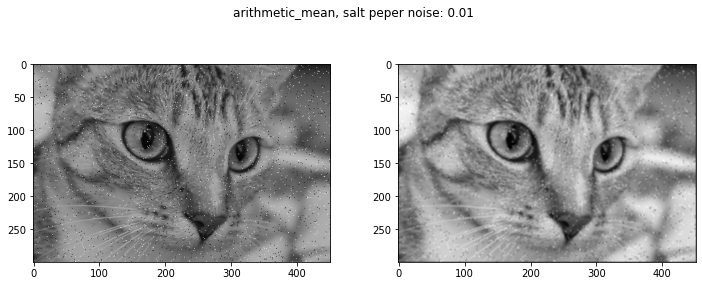

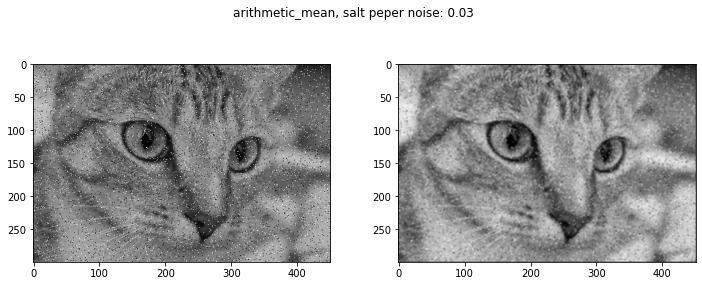

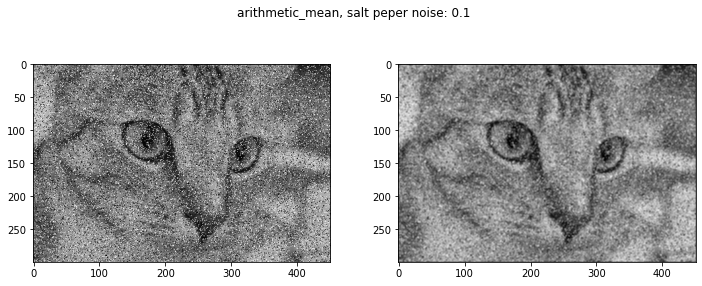

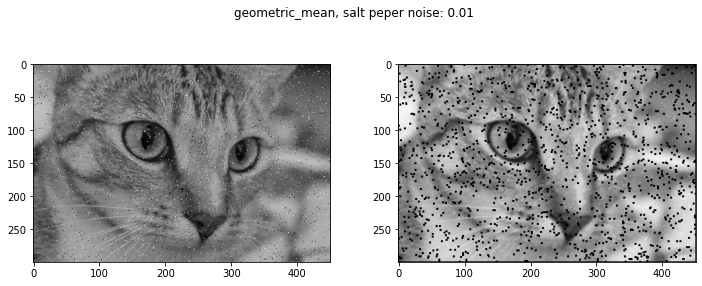

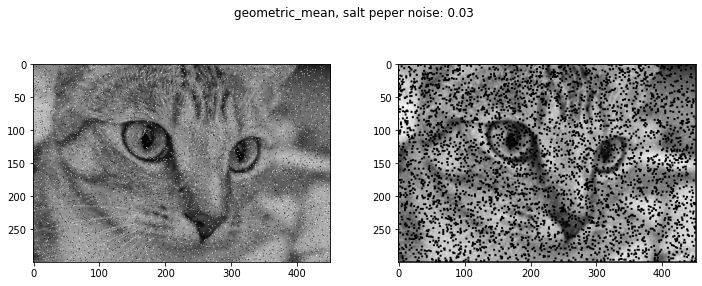

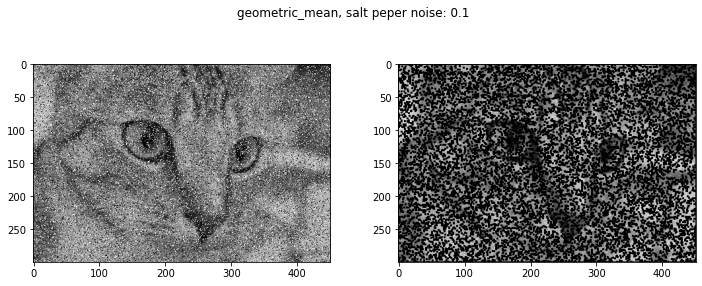

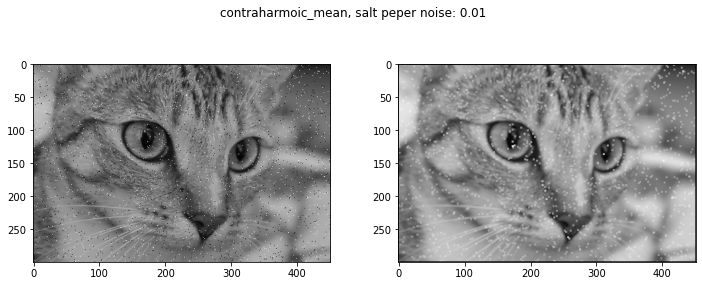

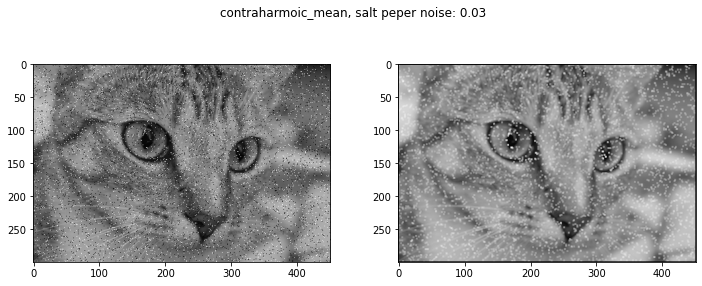

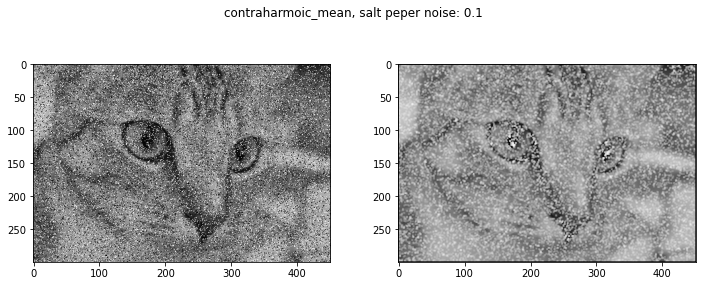

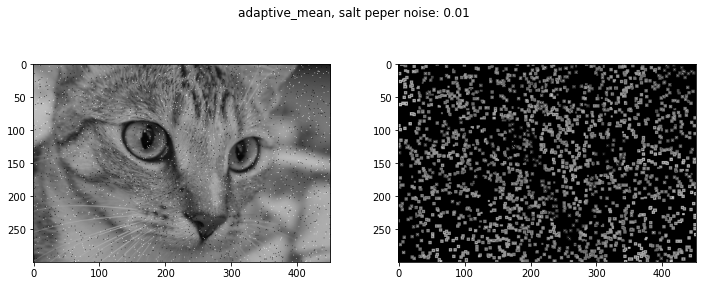

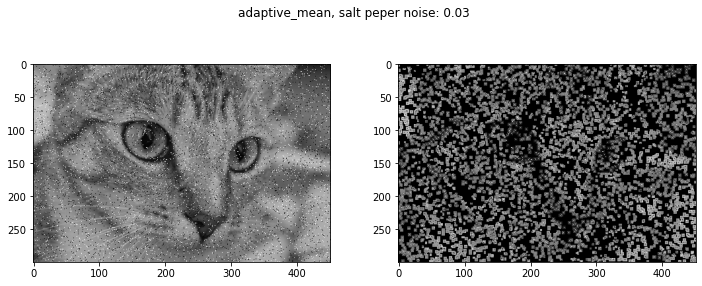

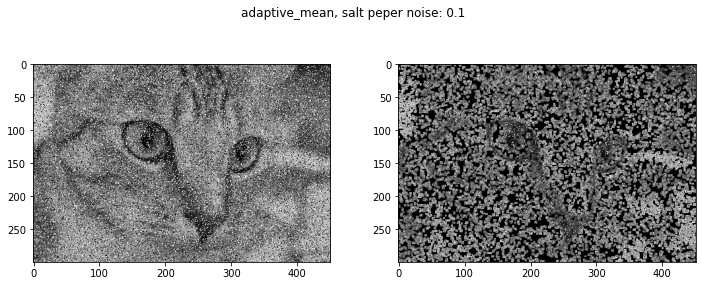

In [ ]:
filters = [arithmetic_mean, geometric_mean, contraharmoic_mean, 
           adaptive_mean, adaptive_median]
for filter in filters:
    for sp, img_sp in zip(salt_peper_noises, imgs_salt_peper):
        plt.suptitle(filter.__name__ + ", salt peper noise: {}".format(sp))
        plt.subplot(221)
        plt.imshow(img_sp, cmap='gray')
        plt.subplot(222)
        plt.imshow(filter(img_sp.copy()), cmap='gray')
        plt.show()


In [ ]:
for filter in filters:
    for gn, img_gn in zip(gaussian_noises, imgs_gaussian_noise):
        plt.suptitle(filter.__name__ + ", gaussian noise: {}".format(gn))
        plt.subplot(221)
        plt.imshow(img_gn, cmap='gray')
        plt.subplot(222)
        plt.imshow(filter(img_gn.copy()), cmap='gray')
        plt.show()

# Exercise 2 - Sharpening - 5 Points

Sharpen the image `img_blurry`. You need to implement the `sharp_laplacian` and `unsharp_masking` functions. You might
consider some processing steps before sharpening.

In [ ]:
from skimage.filters import gaussian

In [ ]:
img_blurry = gaussian_noise(gaussian(img , 1.6), 0.07)
plt.imshow(img_blurry, cmap='gray')

In [ ]:
def sharp_laplacian(img):
    """Perform sharpening with a laplacian filter"""
    # your code here
    result = np.zeros_like(img)
    upper_x = result.shape[1]-1
    upper_y = result.shape[0]-1
    
    for row in range(lower_y, upper_y):
        for column in range(lower_x, upper_x):
            pass
    return resulr

def unsharp_masking(img):
    """Perform sharpening by unsharp masking"""
    # your code here
    return img

In [ ]:
plt.imshow(sharp_laplacian(img_blurry), cmap='gray')
plt.show()

In [ ]:
plt.imshow(unsharp_masking(img_blurry), cmap='gray')
plt.show()